# SDTSIA210 - Machine Learning
## Geoffroy Mateu

# Modules and useful functions

In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.io import arff
import pandas as pd
from keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import auc, confusion_matrix, mean_squared_error, f1_score,roc_auc_score,mean_absolute_error

Using TensorFlow backend.


In [2]:
#To print the confusion matrix

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

classes_name=["label 0","label 1"]

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(20,15))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores, random_state", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Classification binaire - Données sismiques




## Loading and observation of the data

In [3]:
seismic_data, seismic_metadata = arff.loadarff('Documents/TPT/2A/SDTSIA-210/Projet/Bin_class/seismic-bumps.arff')
display(seismic_metadata)

Dataset: seismic-bumps
	seismic's type is nominal, range is ('a', 'b', 'c', 'd')
	seismoacoustic's type is nominal, range is ('a', 'b', 'c', 'd')
	shift's type is nominal, range is ('W', 'N')
	genergy's type is numeric
	gpuls's type is numeric
	gdenergy's type is numeric
	gdpuls's type is numeric
	ghazard's type is nominal, range is ('a', 'b', 'c', 'd')
	nbumps's type is numeric
	nbumps2's type is numeric
	nbumps3's type is numeric
	nbumps4's type is numeric
	nbumps5's type is numeric
	nbumps6's type is numeric
	nbumps7's type is numeric
	nbumps89's type is numeric
	energy's type is numeric
	maxenergy's type is numeric
	class's type is nominal, range is ('1', '0')

In [4]:
input_data = pd.DataFrame(seismic_data)
display(input_data.head())

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


It contains binary strings so we need to first clear the data.

### Clearing the data

In [5]:
######################################################################
#              Clear binary strings of the data set                  #
######################################################################
X = input_data.iloc[:,:18]

for stri in ['seismic','seismoacoustic','ghazard']:
    for i in range(len(X[stri])):
        if X[stri][i] == b'a':
            X[stri][i] = 'a'
        if X[stri][i] == b'b':
            X[stri][i] = 'b'
        if X[stri][i] == b'c':
            X[stri][i] = 'c'
        if X[stri][i] == b'd':
            X[stri][i] = 'd'

for i in range(len(X['shift'])):
    if X['shift'][i] == b'N':
        X['shift'][i] = 'N'
    if X['shift'][i] == b'W':
        X['shift'][i] = 'W'

######################################################################
#              Clear binary strings of the label set                 #
######################################################################

input_data['class'] = input_data['class'].map({b'0': 0, b'1': 1})
Y = input_data['class']

######################################################################
#          Preparing set for machine learning algorithms             #
######################################################################

input_data_categorical = X.copy()
cols = ['seismic', 'seismoacoustic', 'shift', 'ghazard']
dummies = pd.get_dummies(input_data_categorical, columns=cols)

print("The shape of the labels is ",Y.shape,".")
print("The training set consists of labels: ",np.unique(Y))
print("The shape of the observations is",dummies.shape,".")
print("We work with",dummies.shape[0],"data and each one has",dummies.shape[1],"features.")

/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

The shape of the labels is  (2584,) .
The training set consists of labels:  [0 1]
The shape of the observations is (2584, 24) .
We work with 2584 data and each one has 24 features.


The data is unbalanced as we can see below.

6.578947368421052 % of the observations have the label 1.
93.42105263157895 % of the observations have the label 0.


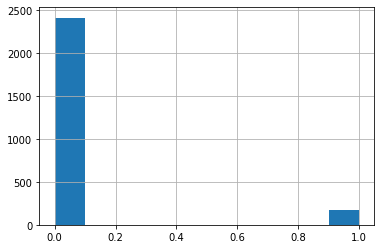

In [6]:

Y.hist()
print(str(Y.mean()*100),"% of the observations have the label 1.")
print(str((1-Y.mean())*100),"% of the observations have the label 0.")

### Scaling the data

By applying this to the dataset, we prevent some features to be more important than others. Since we do not have any infos of how important some features may be regarding others, we normalize everything to make their average equal to 0 with a unit variance.

In [7]:
scaler = StandardScaler()
scaler.fit(dummies)
X_scale = scaler.transform(dummies)
X_scale = pd.DataFrame(X_scale)
X_train, X_test, y_train, y_test = train_test_split(X_scale, Y, test_size=0.33, random_state=42)

## 1. First approach using KNN

Knn is a very simple model. We use it to make a first test and see if we can draw some conclusions.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
#We want to test 30 different values for each neighbor
params_knn = {'n_neighbors': np.arange(1, 10)}
#use gridsearch to test all values for n_neighbors (n_jobs = - 1 to enable concurrent programming)
knn_gs = GridSearchCV(knn, params_knn, cv=20)
#fit model to training data
knn_gs.fit(X_train, y_train)
#save best model
knn_best = knn_gs.best_estimator_


{'n_neighbors': 6}
The best model is:  {'n_neighbors': 6}
This model produces a mean cross-validated score (precision) of 0.9364875701684042
precision on the evaluation set:  0.5
accuracy on the evaluation set:  0.9308323563892146
Normalized confusion matrix
[[0.99748111 0.00251889]
 [0.96610169 0.03389831]]


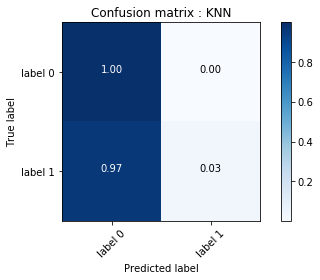

In [9]:
print(knn_gs.best_params_)
print('The best model is: ', knn_gs.best_params_)
print('This model produces a mean cross-validated score (precision) of', knn_gs.best_score_)

y_true, y_pred = y_test, knn_gs.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : KNN")
plt.show()

It predicts very poorly class 1 so I am going to look for another method.

## 2. Linear models : SVM


In [10]:
from sklearn.svm import SVC, LinearSVC
tuned_parameters = [{'kernel': ['rbf'], 'class_weight': ['balanced'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'class_weight': ['balanced'] ,'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'class_weight': ['balanced'], 'C': [1, 10, 100, 1000]}]

svc_gs = GridSearchCV(SVC(), tuned_parameters, cv=5, n_jobs=-1,  scoring="roc_auc",verbose=1)
svc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   27.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbo

In [11]:
from sklearn.svm import SVC, LinearSVC
tuned_parameters = {'C':[0.01,0.1,1,10,100,1000], 'class_weight': [{0:1,1:1},{0:1,1:5},{0:1,1:15}]}
print(LinearSVC().get_params().keys())
lsvc_gs = GridSearchCV(LinearSVC(), tuned_parameters, cv=5,  scoring="roc_auc",verbose=1)
lsvc_gs.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5},
                                          {0: 1, 1: 15}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

{'C': 0.01, 'class_weight': {0: 1, 1: 15}}
The best model is:  {'C': 0.01, 'class_weight': {0: 1, 1: 15}}
This model produces a mean cross-validated score (precision) of 0.7449555945932758
precision on the evaluation set:  0.16194331983805668
accuracy on the evaluation set:  0.735052754982415
Normalized confusion matrix
[[0.73929471 0.26070529]
 [0.3220339  0.6779661 ]]


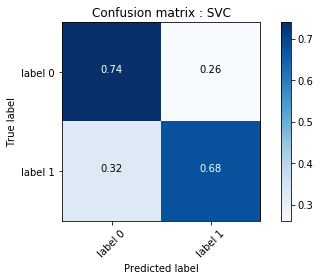

In [12]:
print(lsvc_gs.best_params_)
print('The best model is: ', lsvc_gs.best_params_)
print('This model produces a mean cross-validated score (precision) of', lsvc_gs.best_score_)

y_true, y_pred = y_test, lsvc_gs.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : SVC")
plt.show()

Prediction of label 1 is better, but we pay it with a lot of errors of prediction on label 1.

## 3. Neural Networks

Train on 1731 samples, validate on 853 samples
Epoch 1/30
1731/1731 [==============================] - 0s 120us/step - loss: 0.5125 - accuracy: 0.9359 - val_loss: 0.4424 - val_accuracy: 0.9308
Epoch 2/30
1731/1731 [==============================] - 0s 35us/step - loss: 0.3718 - accuracy: 0.9359 - val_loss: 0.3250 - val_accuracy: 0.9308
Epoch 3/30
1731/1731 [==============================] - 0s 31us/step - loss: 0.2795 - accuracy: 0.9359 - val_loss: 0.2659 - val_accuracy: 0.9308
Epoch 4/30
1731/1731 [==============================] - 0s 29us/step - loss: 0.2390 - accuracy: 0.9359 - val_loss: 0.2415 - val_accuracy: 0.9308
Epoch 5/30
1731/1731 [==============================] - 0s 29us/step - loss: 0.2235 - accuracy: 0.9359 - val_loss: 0.2318 - val_accuracy: 0.9308
Epoch 6/30
1731/1731 [==============================] - 0s 30us/step - loss: 0.2172 - accuracy: 0.9359 - val_loss: 0.2276 - val_accuracy: 0.9308
Epoch 7/30
1731/1731 [==============================] - 0s 29us/step - loss: 0.214

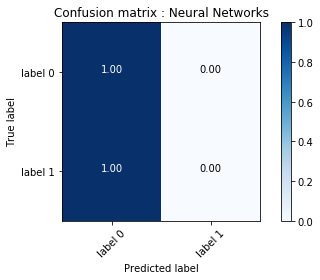

In [15]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Activation, Flatten
from keras import optimizers
from keras.optimizers import SGD

#Xtrain = preprocessing.scale(X_train)
#Xtest = preprocessing.scale(X_test)

dataset = X_train.copy()
labels = y_train.copy()

input_dim = 24

epochs = 30


model = Sequential()
model.add(Dense(8, activation='relu',input_dim=input_dim))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



model.compile(optimizer='adam',
            loss='binary_crossentropy', metrics=['accuracy'])
f = model.fit(dataset,labels,epochs=epochs,batch_size=32, verbose=1, validation_data=(X_test, y_test), shuffle=True)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_true = y_test


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : Neural Networks")
plt.show()


In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

res=[]
for i in range(10,200,20):
    for j in range(10,100,10):
        res.append((i,j))
    res.append((i,))

param = {
    'hidden_layer_sizes': res,
    'learning_rate':['constant','invscaling'],
    }

model = MLPClassifier(tol=0.00001,max_iter=300)

grid = RandomizedSearchCV(model, param, n_iter=50, cv=5, n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.0min finished
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=300,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                                               (10, 50),
                                                               (10, 60),
                                 

The best model is:  {'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,)}
This model produces a mean cross-validated score (precision) of 0.9335643250986989
precision on the evaluation set:  0.6666666666666666
accuracy on the evaluation set:  0.9320046893317703
Normalized confusion matrix
[[0.99874055 0.00125945]
 [0.96610169 0.03389831]]


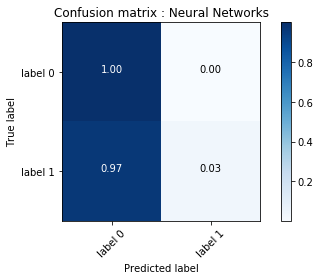

In [17]:
print('The best model is: ', grid.best_params_)
print('This model produces a mean cross-validated score (precision) of', grid.best_score_)

y_true, y_pred = y_test, grid.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : Neural Networks")
plt.show()

## 4. Random Forrest

In [18]:
from sklearn.ensemble import RandomForestClassifier

############################# First we apply a grid search to see which parameter is the best######
rfclass = RandomForestClassifier()

#Create a dictionnary of all values we want to test for n_estimators, aka the number of trees
param_rf = { 
    'n_estimators': [1,20,50, 100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4],
    'criterion' :['entropy', 'gini']
}

#use gridsearch to test all values for n_estimators
modelRF_gs = GridSearchCV(rfclass, param_grid=param_rf, n_jobs=-1, cv=10, verbose=1, scoring="roc_auc")

# Fit on training data
modelRF_gs.fit(X_train, y_train)


Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The best model is:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 20}
This model produces a mean cross-validated score (precision) of 0.776225215114104
precision on the evaluation set:  0.0
accuracy on the evaluation set:  0.9308323563892146
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


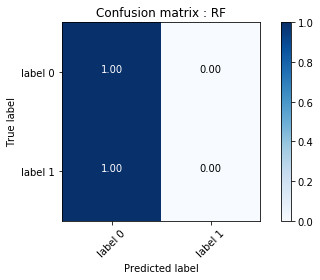

In [19]:
print('The best model is: ', modelRF_gs.best_params_)
print('This model produces a mean cross-validated score (precision) of', modelRF_gs.best_score_)

y_true, y_pred = y_test, modelRF_gs.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : RF")
plt.show()

## 5. XGBoost

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1546s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0192s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:   11.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.1s finished
/usr/local/lib/python3.7/site-packages/sklearn/

[21:49:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classification done in 12.273879051208496s
This model produces a mean cross-validated score (precision) of 0.7486236236236237
precision on the evaluation set:  0.0
accuracy on the evaluation set:  0.9308323563892146
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


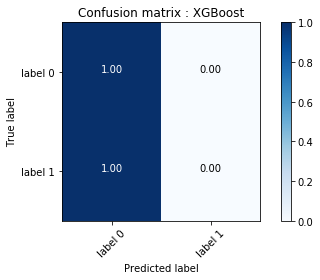

In [ ]:
from scipy.stats import uniform, randint
from time import time
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

t0 = time()
seed = 42
params_fixed={'objective':'binary:logistic','silent':0}
params_dist_grid={
    'max_depth':range(3,10,2),
    'gamma':[0,0.5,1],
    'n_estimators':randint(30,500),
    'learning_rate':uniform(),
    'subsample':uniform(),
    'colsample_bytree':uniform()
}
rd_grid=RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed,seed=seed),param_distributions=params_dist_grid,
n_iter=50,
cv=3,
scoring="roc_auc",
random_state=seed,
verbose=10,
n_jobs=-1
)
rd_grid.fit(X_train,y_train)

print("Classification done in "+str(time() - t0)+"s")

#print('The best model is: ', rd_grid.best_params_)
print('This model produces a mean cross-validated score (precision) of', rd_grid.best_score_)

y_true, y_pred = y_test, rd_grid.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : XGBoost")
plt.show()

## Unbalanced output problem

## Up-sampling the '1' class

In order to fix the issue of unbalanced output, we can generate new data to have a little bit more of '1' label. This allows us to train our data on a set with a greater amount of '1'. However, it is needed to test our data on the original dataset and not the dataset with new data generated.

We won't use accuracy since it is not adapted for unbalanced data. We will choose ROC or f1 instead.

## Loading and observation of the data

In [21]:
seismic_data, seismic_metadata = arff.loadarff('Documents/TPT/2A/SDTSIA-210/Projet/Bin_class/seismic-bumps.arff')
display(seismic_metadata)

Dataset: seismic-bumps
	seismic's type is nominal, range is ('a', 'b', 'c', 'd')
	seismoacoustic's type is nominal, range is ('a', 'b', 'c', 'd')
	shift's type is nominal, range is ('W', 'N')
	genergy's type is numeric
	gpuls's type is numeric
	gdenergy's type is numeric
	gdpuls's type is numeric
	ghazard's type is nominal, range is ('a', 'b', 'c', 'd')
	nbumps's type is numeric
	nbumps2's type is numeric
	nbumps3's type is numeric
	nbumps4's type is numeric
	nbumps5's type is numeric
	nbumps6's type is numeric
	nbumps7's type is numeric
	nbumps89's type is numeric
	energy's type is numeric
	maxenergy's type is numeric
	class's type is nominal, range is ('1', '0')

In [22]:
input_data = pd.DataFrame(seismic_data)
display(input_data.head())

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


It contains binary strings so we need to first clear the data.

### Clearing the data

In [23]:
######################################################################
#              Clear binary strings of the data set                  #
######################################################################

for stri in ['seismic','seismoacoustic','ghazard']:
    for i in range(len(input_data[stri])):
        if input_data[stri][i] == b'a':
            input_data[stri][i] = 'a'
        if input_data[stri][i] == b'b':
            input_data[stri][i] = 'b'
        if input_data[stri][i] == b'c':
            input_data[stri][i] = 'c'
        if input_data[stri][i] == b'd':
            input_data[stri][i] = 'd'

for i in range(len(input_data['shift'])):
    if input_data['shift'][i] == b'N':
        input_data['shift'][i] = 'N'
    if input_data['shift'][i] == b'W':
        input_data['shift'][i] = 'W'
######################################################################
#              Clear binary strings of the label set                 #
######################################################################

input_data['class'] = input_data['class'].map({b'0': 0, b'1': 1})

from sklearn.utils import resample

#separate 0 and 1 classes
data_majority = input_data[input_data['class'] == 0]
data_minority = input_data[input_data['class'] == 1]

zero_samples = int(data_majority.shape[0] / 2 )

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=zero_samples,    # to match majority class
                                 random_state=123) # reproducible results

dataProcessed_balanced = pd.concat([data_majority, data_minority_upsampled])

X = dataProcessed_balanced.iloc[:,:18]
Y = dataProcessed_balanced['class']


######################################################################
#          Preparing set for machine learning algorithms             #
######################################################################
input_data_categorical = X.copy()
cols = ['seismic', 'seismoacoustic', 'shift', 'ghazard']
dummies = pd.get_dummies(input_data_categorical, columns=cols)

print("The shape of the labels is ",Y.shape,".")
print("The training set consists of labels: ",np.unique(Y))
print("The shape of the observations is",dummies.shape,".")
print("We work with",dummies.shape[0],"data and each one has",dummies.shape[1],"features.")


/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

The shape of the labels is  (3621,) .
The training set consists of labels:  [0 1]
The shape of the observations is (3621, 24) .
We work with 3621 data and each one has 24 features.


/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/geoffhome/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The data is unbalanced as we can see below.

33.33333333333333 % of the observations have the label 1.
66.66666666666667 % of the observations have the label 0.


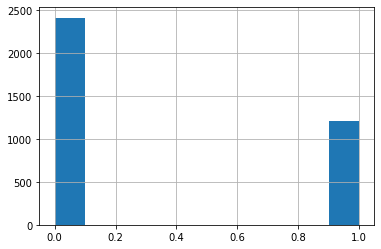

In [24]:

Y.hist()
print(str(Y.mean()*100),"% of the observations have the label 1.")
print(str((1-Y.mean())*100),"% of the observations have the label 0.")

### Scaling the data

By applying this to the dataset, we prevent some features to be more important than others. Since we do not have any infos of how important some features may be regarding others, we normalize everything to make their average equal to 0 with a unit variance.

In [25]:
scaler = StandardScaler()
scaler.fit(dummies)
X_scale = scaler.transform(dummies)
X_scale = pd.DataFrame(X_scale)
X_train, X_test_new, y_train, y_test_new = train_test_split(X_scale, Y, test_size=0.33, random_state=42)

## 1. Random Forrest

In [26]:
from sklearn.ensemble import RandomForestClassifier

############################# First we apply a grid search to see which parameter is the best######
rfclass = RandomForestClassifier()

#Create a dictionnary of all values we want to test for n_estimators, aka the number of trees
param_rf = { 
    'n_estimators': [1,20,50, 100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4],
    'criterion' :['entropy', 'gini']
}

#use gridsearch to test all values for n_estimators
modelRF_gs = GridSearchCV(rfclass, param_grid=param_rf, n_jobs=-1, cv=10, verbose=1,  scoring="roc_auc")

# Fit on training data
modelRF_gs.fit(X_train, y_train)


Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

The best model is:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
This model produces a mean cross-validated score (precision) of 0.832587860366309
(853,)
(853,)
(853, 24)
precision on the evaluation set:  0.23353293413173654
accuracy on the evaluation set:  0.8264947245017585
Normalized confusion matrix
[[0.83879093 0.16120907]
 [0.33898305 0.66101695]]


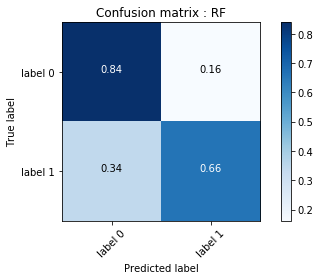

In [27]:
print('The best model is: ', modelRF_gs.best_params_)
print('This model produces a mean cross-validated score (precision) of', modelRF_gs.best_score_)

y_true, y_pred = y_test, modelRF_gs.predict(X_test)
print(y_true.shape)
print(y_pred.shape)
print(X_test.shape)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : RF")
plt.show()

## 2. XGBoost

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:   11.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.9s finished


[22:12:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classification done in 13.321921825408936s
This model produces a mean cross-validated score (precision) of 0.9278149144959297
precision on the evaluation set:  0.4714285714285714
accuracy on the evaluation set:  0.9261430246189918
Normalized confusion matrix
[[0.9534005  0.0465995 ]
 [0.44067797 0.55932203]]


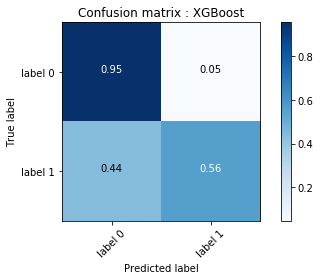

In [28]:
from scipy.stats import uniform, randint
from time import time
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

t0 = time()
seed = 42
params_fixed={'objective':'binary:logistic','silent':0}
params_dist_grid={
    'max_depth':range(3,10,2),
    'gamma':[0,0.5,1],
    'n_estimators':randint(30,500),
    'learning_rate':uniform(),
    'subsample':uniform(),
    'colsample_bytree':uniform()
}
rd_grid=RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed,seed=seed),param_distributions=params_dist_grid,
n_iter=50,
cv=3,
scoring='f1',
random_state=seed,
verbose=10,
n_jobs=-1
)
rd_grid.fit(X_train,y_train)

print("Classification done in "+ str(time() - t0)+"s")

#print('The best model is: ', rd_grid.best_params_)
print('This model produces a mean cross-validated score (precision) of', rd_grid.best_score_)

y_true, y_pred = y_test, rd_grid.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : XGBoost")
plt.show()

## 3. Neural Networks

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

res=[]
for i in range(10,200,20):
    for j in range(10,100,10):
        res.append((i,j))
    res.append((i,))

param = {
    'hidden_layer_sizes': res,
    'learning_rate':['constant','invscaling'],
    }

model = MLPClassifier(tol=0.00001,max_iter=300)

grid = RandomizedSearchCV(model, param, n_iter=50, cv=5, n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=300,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                                               (10, 50),
                                                               (10, 60),
                                 

In [ ]:
print(y_train.shape)
print(f.history.keys())

(2426,)
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


The best model is:  {'learning_rate': 'invscaling', 'hidden_layer_sizes': (190, 20)}
This model produces a mean cross-validated score (precision) of 0.9159119256713758
precision on the evaluation set:  0.44545454545454544
accuracy on the evaluation set:  0.9167643610785463
Normalized confusion matrix
[[0.9231738  0.0768262 ]
 [0.16949153 0.83050847]]


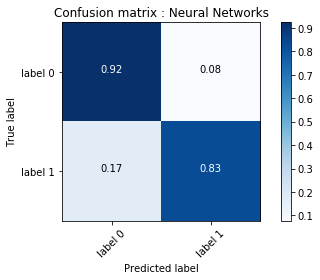

In [30]:
print('The best model is: ', grid.best_params_)
print('This model produces a mean cross-validated score (precision) of', grid.best_score_)

y_true, y_pred = y_test, grid.predict(X_test)
print('precision on the evaluation set: ', precision_score(y_true, y_pred))
print('accuracy on the evaluation set: ', accuracy_score(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
y_classes = np.where(y_pred > 0.5, 1,0)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = classes_name ,normalize=True)
plt.title("Confusion matrix : Neural Networks")
plt.show()

Neural Networks' method gives quite good results. 

# Multi-class Classification - Handwritten numerals
This dataset consists of features of handwritten numerals ('0'--'9') extracted from a collection of Dutch utility maps

In [124]:
file = open("Documents/TPT/2A/SDTSIA-210/Projet/Class/mfeat/mfeat-pix", "r")

data = file.read().split()
data = np.array(list(map(int, data)))
data = np.reshape(data,(2000,240))
file.close()

# afficher une image
#plt.imshow(data[1600].reshape((16,15)), cmap=plt.cm.gray_r, interpolation='nearest')
#plt.show()

In [125]:
import random
A = np.ones(200)
X = data.copy()
y = np.concatenate([i*A for i in range(0,10)])
c = list(zip(X, y))
random.shuffle(c)

X,y = zip(*c)
print(y)


(6.0, 4.0, 7.0, 0.0, 1.0, 3.0, 6.0, 7.0, 2.0, 0.0, 4.0, 9.0, 7.0, 0.0, 9.0, 2.0, 8.0, 0.0, 0.0, 6.0, 0.0, 8.0, 4.0, 9.0, 3.0, 4.0, 7.0, 9.0, 9.0, 1.0, 7.0, 5.0, 1.0, 3.0, 5.0, 6.0, 7.0, 6.0, 3.0, 2.0, 3.0, 9.0, 6.0, 7.0, 4.0, 0.0, 6.0, 1.0, 8.0, 5.0, 5.0, 2.0, 7.0, 7.0, 7.0, 7.0, 8.0, 5.0, 9.0, 7.0, 0.0, 6.0, 4.0, 8.0, 7.0, 0.0, 5.0, 5.0, 6.0, 3.0, 7.0, 4.0, 9.0, 4.0, 4.0, 6.0, 3.0, 6.0, 2.0, 2.0, 4.0, 8.0, 0.0, 4.0, 6.0, 9.0, 4.0, 9.0, 4.0, 2.0, 4.0, 2.0, 5.0, 0.0, 3.0, 8.0, 7.0, 0.0, 3.0, 2.0, 4.0, 4.0, 4.0, 8.0, 5.0, 0.0, 1.0, 4.0, 8.0, 5.0, 5.0, 1.0, 0.0, 6.0, 3.0, 1.0, 3.0, 6.0, 9.0, 1.0, 9.0, 1.0, 9.0, 4.0, 9.0, 8.0, 4.0, 3.0, 4.0, 4.0, 1.0, 0.0, 2.0, 1.0, 3.0, 3.0, 8.0, 4.0, 1.0, 8.0, 6.0, 2.0, 8.0, 0.0, 3.0, 5.0, 6.0, 1.0, 8.0, 3.0, 7.0, 7.0, 4.0, 7.0, 5.0, 3.0, 6.0, 3.0, 7.0, 9.0, 5.0, 0.0, 2.0, 7.0, 6.0, 2.0, 7.0, 3.0, 4.0, 6.0, 0.0, 7.0, 2.0, 7.0, 7.0, 6.0, 2.0, 7.0, 3.0, 2.0, 0.0, 5.0, 5.0, 5.0, 1.0, 3.0, 7.0, 2.0, 8.0, 8.0, 4.0, 3.0, 5.0, 6.0, 1.0, 6.0, 1.0, 0.0, 6.0, 1.0,

In [126]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.20)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [127]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)
print(X_test.shape)
print(y_test.shape)


(400, 240)
(400, 10)


In [128]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import optimizers


## Size of the hidden layer

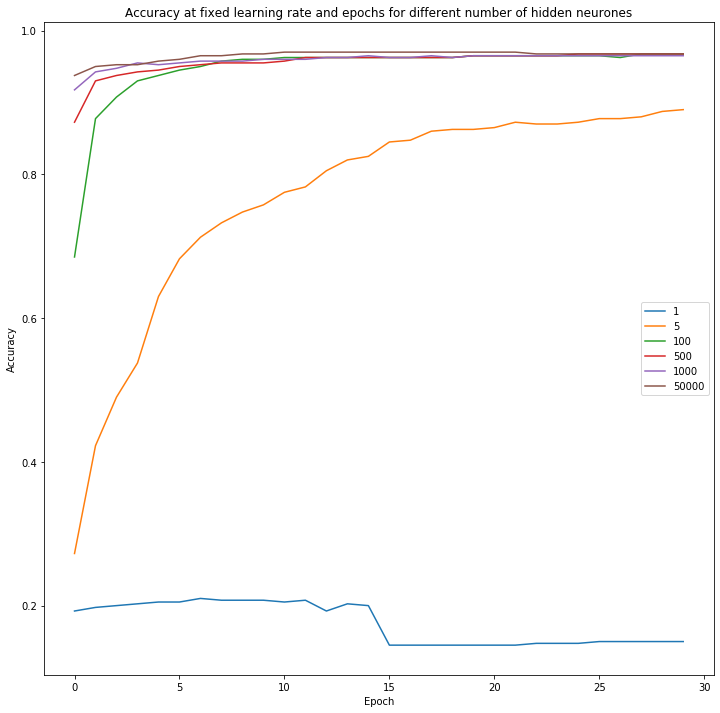

In [121]:
n_i = X_train.shape[1]

# Size of hidden layer
n_h = [1, 5, 100, 500, 1000, 50000]
n_o = 10
epochs = 30
plt.figure(figsize=(12, 12))


for i in range(len(n_h)):
    model = Sequential()
    model.add(Dense(n_h[i], input_dim=n_i))
    model.add(Activation("tanh"))
    model.add(Dense(n_o))
    model.add(Activation("softmax"))

    model.compile(optimizer=optimizers.SGD(lr=0.01),
                loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    f = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=False, validation_data=(X_test, y_test))
    plt.plot(f.history['val_categorical_accuracy'], label=n_h[i])

plt.title('Accuracy at fixed learning rate and epochs for different number of hidden neurones')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


We choose 500 because it reaches converges like the higher values while still being low.

## Which activation function ?

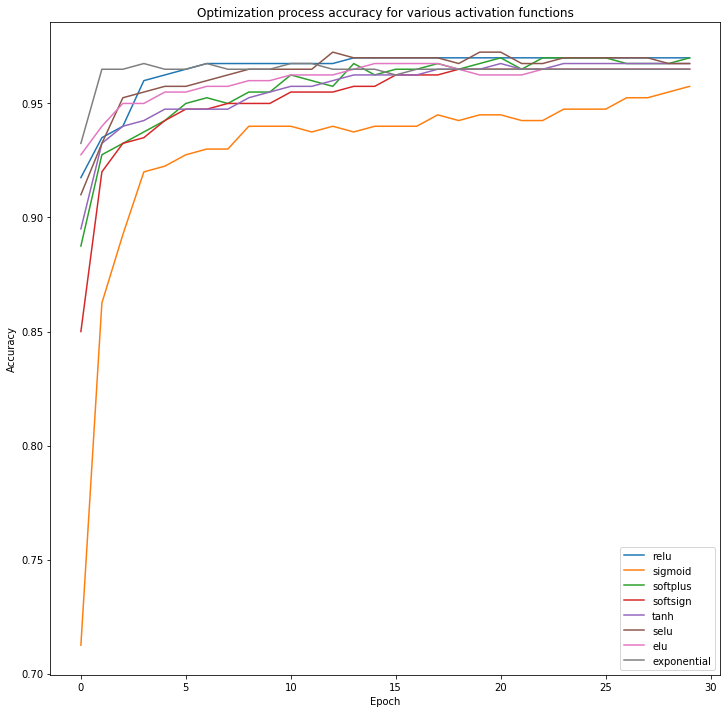

In [129]:
activation_func = ['relu','sigmoid','softplus','softsign','tanh','selu','elu','exponential']
n_h = 500
n_o = 10
epochs = 30

lr = [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]
plt.figure(figsize=(12, 12))

for i in range(len(activation_func)):
    model = Sequential()
    model.add(Dense(n_h, input_dim=n_i))
    model.add(Activation(activation_func[i]))
    model.add(Dense(n_o))
    model.add(Activation("softmax"))

    model.compile(optimizer=optimizers.SGD(lr=0.01),
                loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    f = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=False, validation_data=(X_test, y_test))
    plt.plot(f.history['val_categorical_accuracy'], label=activation_func[i])

plt.title('Optimization process accuracy for various activation functions')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We will choose relu or selu for activation functions.

## Learning rate tuning

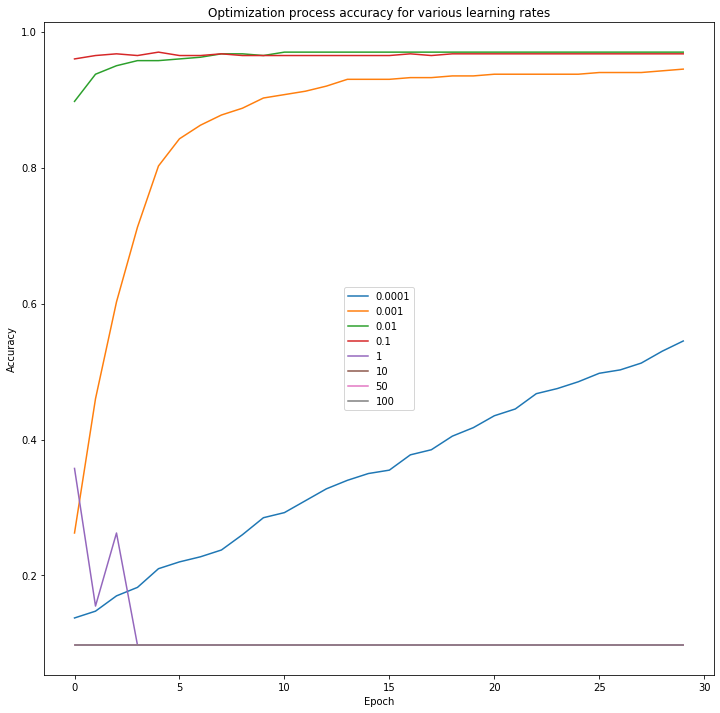

In [130]:
n_h = 500
n_o = 10
epochs = 30

lr = [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]
plt.figure(figsize=(12, 12))

for i in range(len(lr)):
    model = Sequential()
    model.add(Dense(n_h, input_dim=n_i))
    model.add(Activation("relu"))
    model.add(Dense(n_o))
    model.add(Activation("softmax"))

    model.compile(optimizer=optimizers.SGD(lr=lr[i]),
                loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    f = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=False, validation_data=(X_test, y_test))
    plt.plot(f.history['val_categorical_accuracy'], label=lr[i])

plt.title('Optimization process accuracy for various learning rates')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We choose 0.1 for its highest performance.

## Optimizer tuning

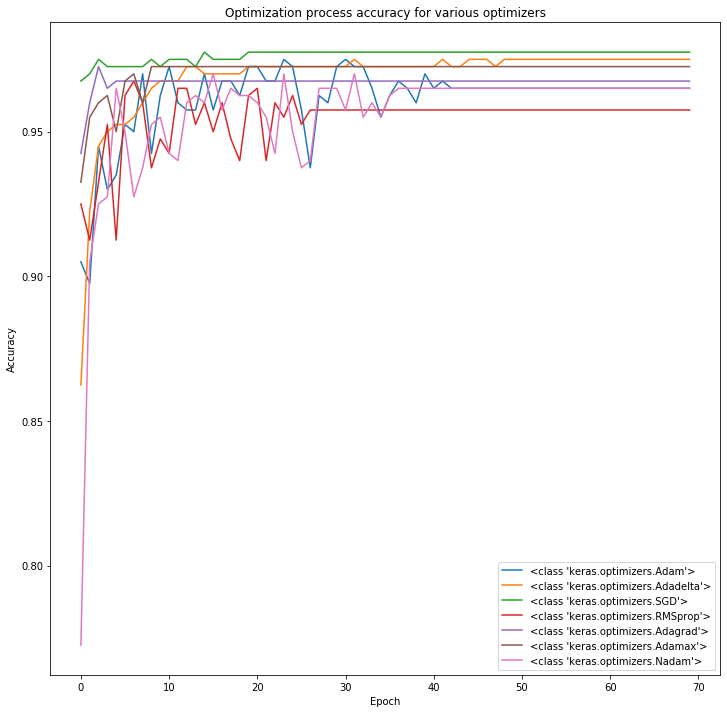

In [131]:

opt = [optimizers.Adam, optimizers.Adadelta, optimizers.SGD,optimizers.RMSprop,optimizers.Adagrad,optimizers.Adamax,optimizers.Nadam]

plt.figure(figsize=(12, 12))
for i in range(len(opt)):
    model = Sequential()
    model.add(Dense(n_h, input_dim=n_i))
    model.add(Activation("relu"))
    model.add(Dense(n_o))
    model.add(Activation("softmax"))

    model.compile(optimizer=opt[i](lr=0.1),
                loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    f = model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=False, validation_data=(X_test, y_test))
    plt.plot(f.history['val_categorical_accuracy'], label=opt[i])

plt.title('Optimization process accuracy for various optimizers')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We will choose SGD for optimization purposes.

## Which batch size

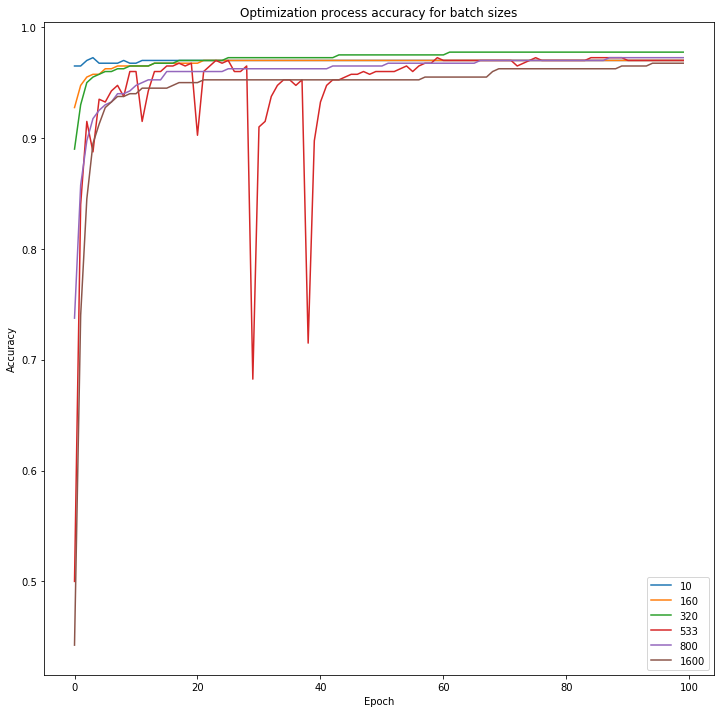

In [132]:
n = X_train.shape[0]
batch_tab = [10,int(n/10),int(n/5), int(n/3), int(n/2), n]

plt.figure(figsize=(12, 12))
for i in range(len(batch_tab)):
    model = Sequential()
    model.add(Dense(n_h, input_dim=n_i))
    model.add(Activation("relu"))
    model.add(Dense(n_o))
    model.add(Activation("softmax"))

    model.compile(optimizer=optimizers.SGD(lr=0.1),
                loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    f = model.fit(X_train, y_train, epochs=100, batch_size=batch_tab[i], verbose=False, validation_data=(X_test, y_test))
    plt.plot(f.history['val_categorical_accuracy'], label=batch_tab[i])

plt.title('Optimization process accuracy for batch sizes')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We will choose 320 for the batch size.

## Different standard deviations

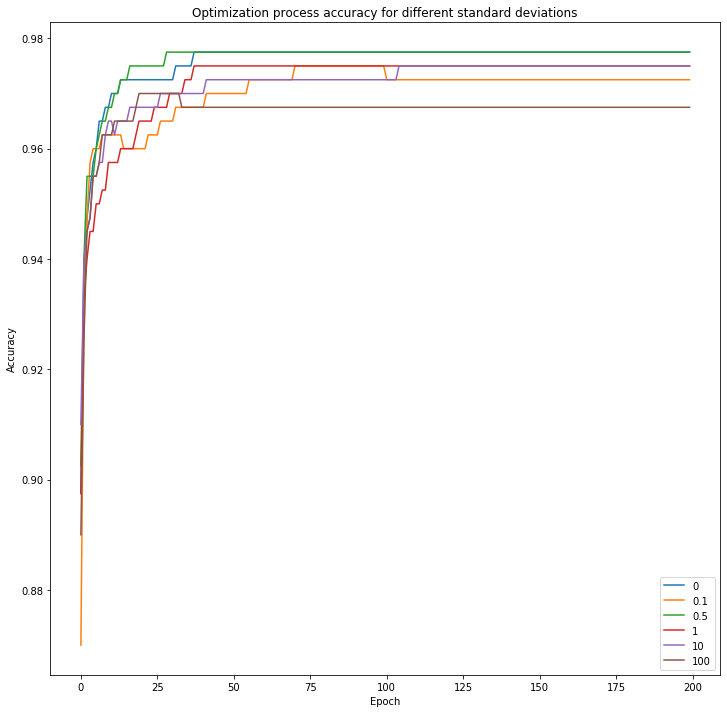

In [133]:
from keras import initializers
std = [0, 0.1, 0.5, 1, 10, 100]
batch_size=320

plt.figure(figsize=(12, 12))
for i in range(len(std)):
    model = Sequential()
    initializer = initializers.RandomNormal(mean=0, stddev=std[i], seed=None)
    model.add(Dense(n_h, input_dim=n_i))
    model.add(Activation("relu"))
    model.add(Dense(n_o))
    model.add(Activation("softmax"))

    model.compile(optimizer=optimizers.SGD(lr=0.1),
                loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    f = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=False, validation_data=(X_test, y_test))
    plt.plot(f.history['val_categorical_accuracy'], label=std[i])

plt.title('Optimization process accuracy for different standard deviations')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Let's resume all the parameters.

1. size of the hidden layer : **500**
2. Activation function : **relu**
3. Learning rate : **0.1**
4. Optimizer : **SGD**
5. Batch size : **320**



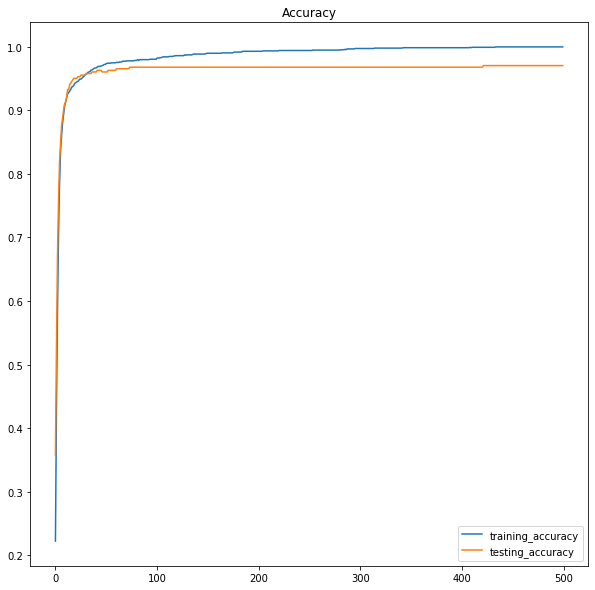

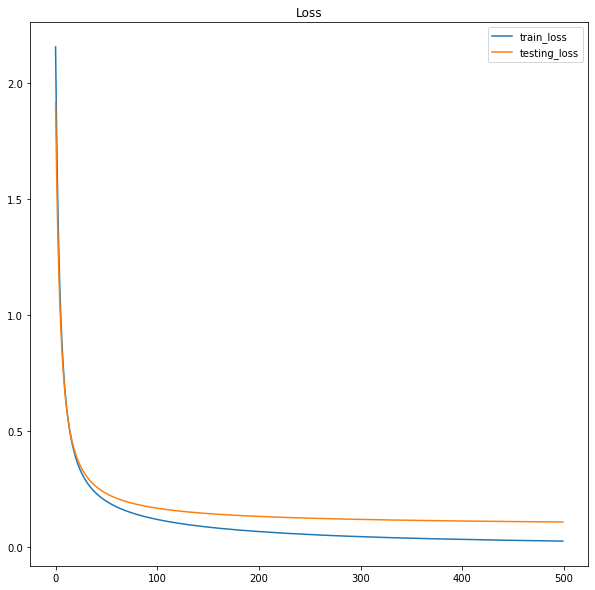

In [134]:
n_i = X_train.shape[1]
n_o = y_train.shape[1]

#parameters
n_h = 500
activation_func = 'relu'
lr = 0.01
optimizer = optimizers.SGD
batch_size = 320

n_epoch = 500

model = Sequential()
model.add(Dense(n_h, input_dim=n_i))
model.add(Activation(activation_func))
model.add(Dense(n_o))
model.add(Activation("softmax"))

model.compile(optimizer=optimizer(lr),
            loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=batch_size, verbose=False, validation_data=(X_test, y_test), shuffle=True)


plt.figure(figsize=(10, 10))
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'],label='training_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='testing_accuracy')
plt.legend(loc='lower right')

plt.figure(figsize=(10, 10))
plt.title('Loss')
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'], label='testing_loss')
plt.legend(loc='upper right')

Accuracy on test data is :  0.98
F1 macro score  on test data is :  0.979790314335737


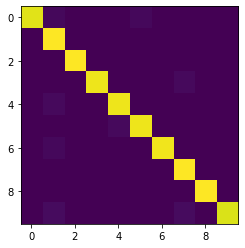

In [98]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
f1 = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1),average='macro')

print("Accuracy on test data is : ", acc)
print("F1 macro score  on test data is : ", f1)

conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')
plt.imshow(conf_mat)

The accuracy is very good and quite the same over the labels. The prediction is efficient with this method.

# Regression : Communities

The goal of this system was to generate a list of matching cities or communities that have relevant similarity, allowing the law enforcement user to contact representatives of the retrieved cities or communities for discussions enabling dialog, discussion and possible learning.

First, we are going to make a clean data frame with the good attributes.

In [142]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
#%matplotlib inline
attributes = read_csv('Documents/TPT/2A/SDTSIA-210/Projet/Regress/attributes.csv', delim_whitespace=True)
data = read_csv('Documents/TPT/2A/SDTSIA-210/Projet/Regress/communities.data', names = attributes['attributes'])

display(data)

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [100]:
print(data.shape)

(1994, 128)


Let's remove non predictive features and deal with the missing data.

In [143]:
from pandas import DataFrame

data = data.replace('?', np.nan)
feat_miss = data.columns[data.isnull().any()]

print(feat_miss)
feat_miss.shape

Index(['county', 'community', 'OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop',
       'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq',
       'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop',
       'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp',
       'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits',
       'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop'],
      dtype='object')


(25,)

From 122 predictive features, 25 contains missing values.
Let's drop the features that have missing values.

In [144]:
data = data.dropna(axis=1)
print(data.shape)


(1994, 103)


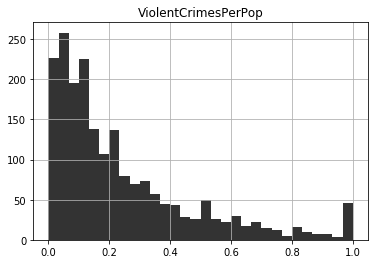

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,6,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,9,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,25,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


In [145]:
data.hist(column = ['ViolentCrimesPerPop'], bins = 30, color = 'black', alpha = 0.8)
plt.show()
display(data)

The scaler and the algorithms can only deal with numeric values. Furthermore, there is a set of non-predictive features that need to be eliminated. These are : __state__, __county__, __community__, __communityname__, __fold__. Some of those have already been eliminated because they contained NaN values.

In [146]:
data = data.drop(columns=['communityname',
                          'fold'], axis=1)

In [147]:
X = data.iloc[:, 0:100].values
y = data.iloc[:, 100].values # violent crimes per pop
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print(X.shape)
print(y.shape)

(1994, 100)
(1994,)


In [148]:
from sklearn.preprocessing import StandardScaler

display(X_train)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

array([[1.8e+01, 8.0e-02, 4.5e-01, ..., 1.7e-01, 7.0e-02, 7.0e-01],
       [4.2e+01, 1.0e-02, 4.0e-01, ..., 7.0e-02, 1.0e-02, 0.0e+00],
       [4.8e+01, 0.0e+00, 5.0e-01, ..., 9.0e-02, 4.0e-02, 0.0e+00],
       ...,
       [4.2e+01, 1.0e-02, 2.9e-01, ..., 3.6e-01, 9.0e-02, 0.0e+00],
       [6.0e+00, 9.0e-02, 2.8e-01, ..., 4.3e-01, 5.2e-01, 0.0e+00],
       [6.0e+00, 9.0e-02, 2.3e-01, ..., 4.7e-01, 2.3e-01, 0.0e+00]])

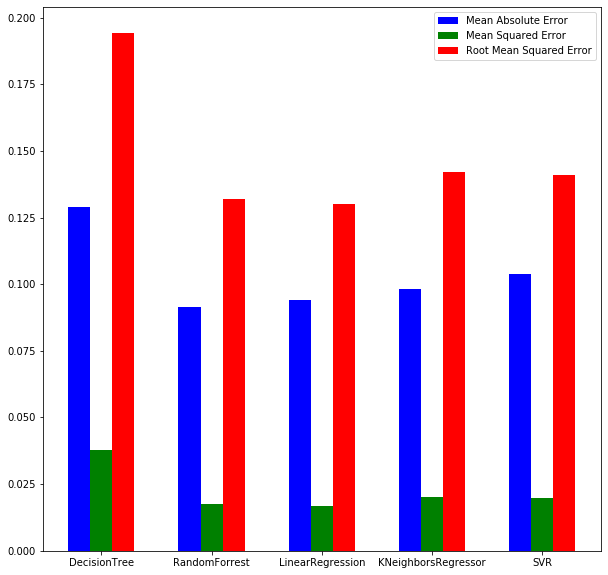

In [107]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
models = [DecisionTreeRegressor(), RandomForestRegressor(), LinearRegression(), KNeighborsRegressor(), SVR()]

metrics_tab = [[],[],[]] # MAE, MSE, RMSE

for i in models:
  i.fit(X_train, y_train)
  y_pred = i.predict(X_test)
  metrics_tab[0].append(metrics.mean_absolute_error(y_test, y_pred))
  metrics_tab[1].append(metrics.mean_squared_error(y_test, y_pred))
  metrics_tab[2].append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

a=["DecisionTree","RandomForrest","LinearRegression", "KNeighborsRegressor","SVR"]
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
x=np.arange(len(a))
ax.bar(x - 0.2, metrics_tab[0], width=0.2, color='b', align='center',label='Mean Absolute Error')
ax.bar(x, metrics_tab[1], width=0.2, color='g', align='center', label='Mean Squared Error')
ax.bar(x+0.2, metrics_tab[2], width=0.2, color='r', align='center', label= 'Root Mean Squared Error')
ax.legend()
plt.xticks(x,a)
plt.show()
  
  

__The most accurate model seems to be the RandomForrest Regressor__.

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

lm = RandomForestRegressor()
mmodel = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print ("Linear model Train dataset score is {}".format(mmodel.score(X_train,y_train)))
print ("Linear model Test dataset score is {}".format(mmodel.score(X_test,y_test)))

##Linear regression using KFold Cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
results = next(kf.split(X), None)



lm = RandomForestRegressor()
mm_scores = cross_val_score(lm,X,y,cv=kf)
print ("Cross Validatation Score is {}".format(mm_scores))
print ("Cross Validatation Score mean is {}".format(mm_scores.mean()))
print ("Cross Validatation standard deviation is {}".format(mm_scores.std()))

Linear model Train dataset score is 0.9511275766170335
Linear model Test dataset score is 0.6432291137765846
Cross Validatation Score is [0.62101931 0.67615818 0.62178075 0.68207496 0.6088276  0.6731196
 0.68513918 0.59230973 0.59419262 0.68890856]
Cross Validatation Score mean is 0.6443530467916294
Cross Validatation standard deviation is 0.03801490588864215
